In [1]:
cd = '005930'
base_date = '2018-01-01'

# 트레이딩 전략 설정
thd = 'ub'   # 종목 매도 기준 (편차구간상단:ub, 편차구간중심:center)
buy = 'in'    # 종목 매수 기준 (편차구간 진입 시:in, 편차구간 벗어날 시:out)
n = 20     # 평균주가계산 기준일수
sigma = 2     # 편차구간 지정 (시그마의 배수로)

In [2]:
import pandas as pd
import finterstellar as fs

In [3]:
# DB에서 읽어오기

dbr = fs.DB_read()
price_df = dbr.make_daily_price_volume_df(cd, base_date)

df = pd.DataFrame()    # 빈 데이터프레임을 생성하고
df[cd] = price_df[cd].copy()    # 시세를 복사해 넣음
df['volume'] = price_df['volume'].copy()    # 시세를 복사해 넣음
df = df.dropna() 

In [4]:
trd = fs.SingleAsset()   # fs 라이브러리의 SingleAsset 모듈을 불러와 trd에 로딩
base_date = trd.check_base_date(df, base_date)
# check_base_date(데이터프레임, 기준일자) - 기준일자가 데이터프레임에 들어있는지 체크
base_date

Timestamp('2018-01-02 00:00:00')

In [5]:
# 볼린저밴드 계산
bb = trd.bollinger_band(df, cd, n, sigma)
# bollinger_band(데이터프레임, 분석대상코드, 평균기준일, 편차구간) - 볼린저밴드 분석값 계산
bb.tail(3)

,005930,center,ub,lb,band_size
trade_time,,,,,
2019-06-11,44850.0,43010.0,45047.697359,40972.302641,4075.394718
2019-06-12,44600.0,43107.5,45256.251167,40958.748833,4297.502335
2019-06-13,43750.0,43167.5,45317.720307,41017.279693,4300.440614


In [6]:
# 샘플링
sample = bb.loc[base_date:]     # 계산 결과를 기준일자 이후만 잘라내 sample 데이터프레임에 저장
sample.tail(3)

,005930,center,ub,lb,band_size
trade_time,,,,,
2019-06-11,44850.0,43010.0,45047.697359,40972.302641,4075.394718
2019-06-12,44600.0,43107.5,45256.251167,40958.748833,4297.502335
2019-06-13,43750.0,43167.5,45317.720307,41017.279693,4300.440614


In [7]:
book = trd.create_trade_book(sample, cd)
# create_trade_book(데이터프레임, [종목코드]) - 트레이딩북 생성
book.head()

,005930,t 005930,p 005930
trade_time,,,
2018-01-02,51020.0,,
2018-01-03,51620.0,,
2018-01-04,51080.0,,
2018-01-05,52120.0,,
2018-01-08,52020.0,,


In [8]:
book = trd.tradings(sample, book, thd, cd, buy, short=False)
# tradings(데이터프레임, 트레이딩북, 매도기준, 종목코드, 매입기준) - 매매전략을 이용한 백테스팅 수행

In [9]:
# 포지션 계산
book = trd.position(book, cd)
# position(트레이딩북, 종목코드) - 트레이딩 전략 수행에 수반되는 포지션 판단
'''
    z : zero
    l : long
    s : short
    zz : zero to zero
    zl : zero to long
    lz : long to zero
'''
book[-10:]

,005930,t 005930,p 005930
trade_time,,,
2019-05-30,42550.0,buy,ll
2019-05-31,42500.0,buy,ll
2019-06-03,43800.0,buy,ll
2019-06-04,43450.0,buy,ll
2019-06-05,43900.0,buy,ll
2019-06-07,44200.0,buy,ll
2019-06-10,44800.0,,lz
2019-06-11,44850.0,,zz
2019-06-12,44600.0,,zz


In [10]:
# 수익률 계산
fund_rtn = trd.returns(book, cd, fee=0.0, display=True)
# returns(트레이딩북, 종목코드) - 전략의 수익률 계산

2018-02-12 00:00:00 long 005930 45720.0
2018-03-13 00:00:00 long 005930 45720.0  | unwind long 005930 51660.0  | return: 12.989999999999998
2018-04-05 00:00:00 long 005930 48740.0
2018-04-19 00:00:00 long 005930 48740.0  | unwind long 005930 52780.0  | return: 8.290000000000001
2018-06-19 00:00:00 long 005930 47000.0
2018-08-31 00:00:00 long 005930 47000.0  | unwind long 005930 48450.0  | return: 3.09
2018-10-12 00:00:00 long 005930 44000.0
2019-01-15 00:00:00 long 005930 44000.0  | unwind long 005930 41100.0  | return: -6.59
2019-03-06 00:00:00 long 005930 44000.0
2019-06-10 00:00:00 long 005930 44000.0  | unwind long 005930 44800.0  | return: 1.82
Accumulated return: 19.96 %  ( # of trade: 5  , # of win: 4  , fee: 0.0  )
Avg return: 0.0371, Prob. of win: 0.8, Kelly ratio: 60.0


In [11]:
# 벤치마크 수익률
bm_rtn = trd.benchmark_return(book, cd)
# benchmark_return(트레이딩북, 종목코드) - 벤치마크 수익률 계산

BM return: -14.25 %
{'005930': 0.8575}


In [12]:
# 초과 수익률
exs_rtn = trd.excess_return(fund_rtn, bm_rtn)
# excess_return(전략수익률, 벤치마크수익률) - 초과수익률 계산

Excess return: 39.9 %


그래프로 표현하기

In [13]:
v = fs.Visualize()    # fs 라이브러리의 Visualize() 모듈을 불러와 v로 지정

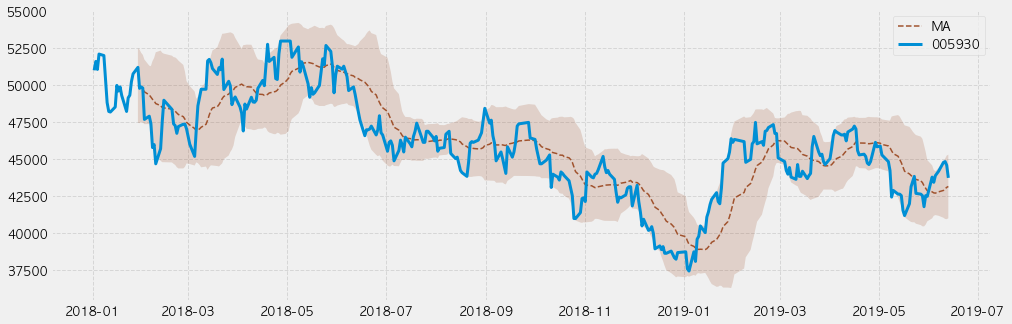

In [14]:
v.BB_trend_view(sample, cd, (15,5))
# v 모듈의 bb_trend_view(데이터프레임, 편차구간, 종목코드, (사이즈)) 함수 - 볼린저밴드 그래프 그리기

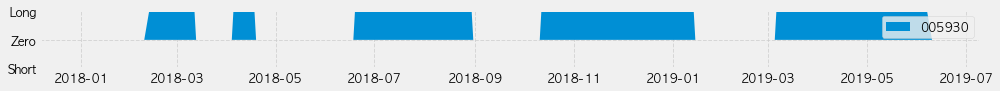

In [15]:
v.position_view(book, cd)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수 - 보유내역 그래프 그리기

최근 전략

In [16]:
last_date = sample.index[-1].date().strftime('%Y-%m-%d')
# 현재 투자전략 추출을 위해 데이터 상 최종일 추출
last_date

'2019-06-13'

In [17]:
trd.trading_strategy(sample, thd, cd, last_date)
# trading_strategy(데이터프레임, 매도기준, 종목코드, 최종일) - 트레이딩 전략 판단

As of 2019-06-13 this model suggests you to just wait


'just wait'

In [18]:
trd.position_strategy(book, cd, last_date)
# position_strategy(트레이딩북, 종목코드 최종일) - 포지션 구축 전략 판단

As of 2019-06-13 your model portfolio ['005930'] needs to be composed of nothing


'nothing'

백테스팅 결과인 트레이딩북을 한번 구경해볼까요?

In [19]:
book[-10:]

,005930,t 005930,p 005930,return,acc return,ps005930
trade_time,,,,,,
2019-05-30,42550.0,buy,ll,1.000000,1.178195,1
2019-05-31,42500.0,buy,ll,1.000000,1.178195,1
2019-06-03,43800.0,buy,ll,1.000000,1.178195,1
2019-06-04,43450.0,buy,ll,1.000000,1.178195,1
2019-06-05,43900.0,buy,ll,1.000000,1.178195,1
2019-06-07,44200.0,buy,ll,1.000000,1.178195,1
2019-06-10,44800.0,,lz,1.018182,1.199617,0
2019-06-11,44850.0,,zz,1.000000,1.199617,0
2019-06-12,44600.0,,zz,1.000000,1.199617,0
